In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sympy import symbols, Eq, sqrt, Sum, IndexedBase
import numpy as np

Dados do relatório

In [2]:
# pressao em cm hm
# erro a menor medição foi 1
dados = {
    'Pi': [8, 12, 9, 15, 14],
    'Pf': [44, 40, 30, 29, 22],
    'N': [10, 8, 6, 4, 2]
}

df = pd.DataFrame(dados)
df['Pi'] = df['Pi'] * 10
df['Pf'] = df['Pf'] * 10
df

,Pi,Pf,N
0,80,440,10
1,120,400,8
2,90,300,6
3,150,290,4
4,140,220,2


In [3]:
from tabulate import tabulate

In [4]:
df.to_dict()

{'Pi': {0: 80, 1: 120, 2: 90, 3: 150, 4: 140},
 'Pf': {0: 440, 1: 400, 2: 300, 3: 290, 4: 220},
 'N': {0: 10, 1: 8, 2: 6, 3: 4, 4: 2}}

In [5]:
print(tabulate(df, headers='keys', tablefmt='mixed_grid'))

┍━━━━┯━━━━━━┯━━━━━━┯━━━━━┑
│    │   Pi │   Pf │   N │
┝━━━━┿━━━━━━┿━━━━━━┿━━━━━┥
│  0 │   80 │  440 │  10 │
├────┼──────┼──────┼─────┤
│  1 │  120 │  400 │   8 │
├────┼──────┼──────┼─────┤
│  2 │   90 │  300 │   6 │
├────┼──────┼──────┼─────┤
│  3 │  150 │  290 │   4 │
├────┼──────┼──────┼─────┤
│  4 │  140 │  220 │   2 │
┕━━━━┷━━━━━━┷━━━━━━┷━━━━━┙


Pi = pressão inicial em mmhg


Pf = pressão final


N = qtd de faixas

# Primeiro gŕafico

Pi - Pf

scatter plot somente para visualização

Aqui é mais para mostrar os dados que coletamos no experimento, ainda não estamos resolvendo nem um dos items propostos no relatório

In [6]:
df['delta_P'] = (df['Pi'] - df['Pf']).abs()

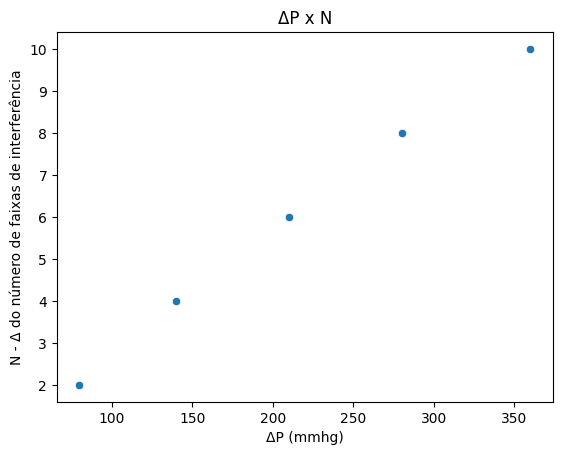

In [7]:
sns.scatterplot(data=df, x='delta_P', y='N')
plt.xlabel("ΔP (mmhg)")
plt.ylabel("N - Δ do número de faixas de interferência")
plt.title("ΔP x N")
plt.show()

# Item 1 e 2)

Primeira regressão linear do problema, vamos identificar a relação entre DeltaP (diferença de pressão) e N (número de faixas)

Equação 5 do relatório (Pin é pressão inicial, o software tratou Pi como o valor matemático 3.14...):

In [8]:
nf, ni, Pf, Pi, N, lambda_0, d = symbols('nf ni Pf Pin N lambda_0 d', real=True)

equation = Eq((nf - ni) / (Pf - Pi), (N * lambda_0) / (2 * d * (Pf - Pi)))
equation

Eq((nf - ni)/(Pf - Pin), N*lambda_0/(2*d*(Pf - Pin)))

simplificando:

In [9]:
equation = Eq((nf - ni), (N * lambda_0) / (2 * d))
equation

Eq(nf - ni, N*lambda_0/(2*d))

sabendo que o índice de refração tem a seguinte relação com a pressão:

In [10]:
n, k, p = symbols("n k p")
Eq(n, 1 + k * p)

Eq(n, k*p + 1)

pela equação acima podemos substituir ni e nf por pi e pf:

In [11]:
nf, ni, Pin, Pf = symbols("nf ni Pin Pf")
Eq(nf - ni, k*(Pf - Pin))

Eq(nf - ni, k*(Pf - Pin))

Então, temos:

In [12]:
k, Pf, Pin, N, lambda_0, d = symbols("k , Pf, Pin, N, lambda_0, d")
Eq(k*(Pf - Pin), N * lambda_0 / (2*d))

Eq(k*(Pf - Pin), N*lambda_0/(2*d))

aqui temos a resposta do item 1)

temos o DeltaP

N são as franjas dos dados que coletamos

d = 3cm (do roteiro)

λ_0 = 632.8 nm (do roteiro)

achando k, podemos substituir na fórmula que relaciona nf - ni = k (Pf - Pin)

assim teremos uma equação que relaciona o índice de refração do e a pressão absoluta do ar.

aqui vamos explorar os dados propostos para encontrar k e resolver o item 1, que é o item 2)

In [13]:
# todas as unidades abaixo estão em METROS
lambda_0 = 632.8e-9
d = 3e-2

df['y'] = df['N'] * lambda_0 / (2* d)

Observe a seguinte equação linear:

y = a * x + b

onde a é o "coef" e b é o "intercept"

as bibliotecas que fazem regressões lineares sempre dão a opção caso queremos ter o "b", no caso que estamos atuando, se olhar na fóruma anterior, vemos que não há
valor "livre", logo para o problema que estamos fazendo não podemos ter o b, assim iremos utilizar fit_intercept = false

In [14]:
ln = LinearRegression(fit_intercept=False)

In [15]:
ln.fit(df[['delta_P']], df[['y']])

LinearRegression(fit_intercept=False)

In [16]:
a = ln.coef_[0][0]

In [33]:
ln.coef_[0][0]*1e7

np.float64(2.9656574373726476)

In [17]:
print(f"a equação linear é dada por y = {a:.7f} * x")

a equação linear é dada por y = 0.0000003 * x


então podemos construir a seguinte relação, (onde delta n é nf - ni (indice de refração final menos inicial)):

In [18]:
df['n_final'] = a * df['delta_P'] + 1

In [25]:
df['predicted'] = ln.predict(df[['delta_P']])

In [28]:
df['predicted'] = df['predicted'] * (2* d) / lambda_0

In [29]:
df

,Pi,Pf,N,delta_P,y,n_final,predicted
0,80,440,10,360,0.000105,1.000107,10.122977
1,120,400,8,280,0.000084,1.000083,7.873427
2,90,300,6,210,0.000063,1.000062,5.905070
3,150,290,4,140,0.000042,1.000042,3.936713
4,140,220,2,80,0.000021,1.000024,2.249551


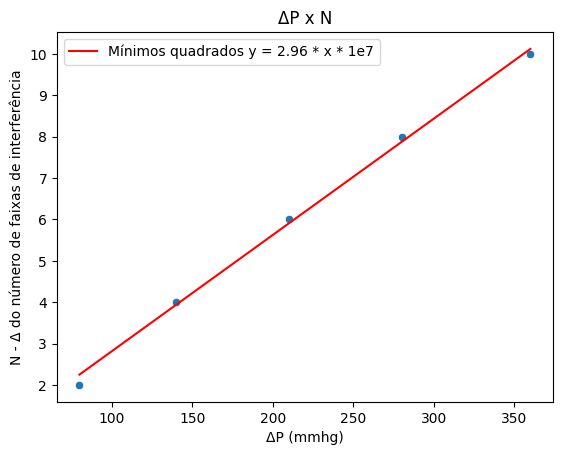

In [34]:
sns.scatterplot(data=df, x='delta_P', y='N')
sns.lineplot(data=df, y='predicted', x='delta_P', color='red', label='Mínimos quadrados y = 2.96 * x * 1e7')
plt.xlabel("ΔP (mmhg)")
plt.ylabel("N - Δ do número de faixas de interferência")
plt.title("ΔP x N")
plt.show()

In [20]:
daidonas

NameError: name 'daidonas' is not defined

# item 3)

Gráfico entre n e Par

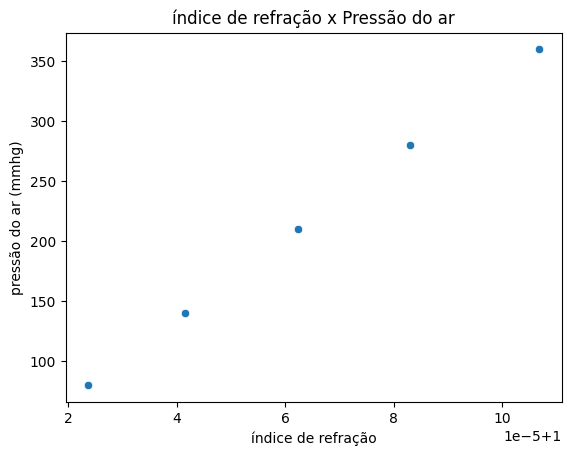

In [ ]:
sns.scatterplot(x=df['n_final'], y=df['delta_P'])
plt.xlabel("índice de refração")
plt.ylabel("pressão do ar (mmhg)")
plt.title("índice de refração x Pressão do ar")
plt.show()

In [ ]:
df['a_err'] = a * (5)/df['delta_P']

In [ ]:
df['a_err'].mean()

np.float64(9.120573468110325e-09)

In [ ]:
df['a_err']

0    4.118969e-09
1    5.295817e-09
2    7.061089e-09
3    1.059163e-08
4    1.853536e-08
Name: a_err, dtype: float64

In [ ]:
df['n_final_erro'] = df['n_final']*np.sqrt(((5)/df['delta_P']) ** 2 + (df['a_err']/a) ** 2)

In [ ]:
print(tabulate(df[['N','delta_P','n_final']], headers='keys', tablefmt='mixed_grid'))

┍━━━━┯━━━━━┯━━━━━━━━━━━┯━━━━━━━━━━━┑
│    │   N │   delta_P │   n_final │
┝━━━━┿━━━━━┿━━━━━━━━━━━┿━━━━━━━━━━━┥
│  0 │  10 │       360 │   1.00011 │
├────┼─────┼───────────┼───────────┤
│  1 │   8 │       280 │   1.00008 │
├────┼─────┼───────────┼───────────┤
│  2 │   6 │       210 │   1.00006 │
├────┼─────┼───────────┼───────────┤
│  3 │   4 │       140 │   1.00004 │
├────┼─────┼───────────┼───────────┤
│  4 │   2 │        80 │   1.00002 │
┕━━━━┷━━━━━┷━━━━━━━━━━━┷━━━━━━━━━━━┙


In [ ]:
df

,Pi,Pf,N,delta_P,y,n_final,a_err,n_final_erro
0,80,440,10,360,0.000105,1.000107,4.118969e-09,0.019644
1,120,400,8,280,0.000084,1.000083,5.295817e-09,0.025256
2,90,300,6,210,0.000063,1.000062,7.061089e-09,0.033674
3,150,290,4,140,0.000042,1.000042,1.059163e-08,0.050510
4,140,220,2,80,0.000021,1.000024,1.853536e-08,0.088390


In [ ]:
df['n_final'].mean()

np.float64(1.0000634650691598)

In [ ]:
df['n_final_erro'].mean()

np.float64(0.043494776038038155)

In [ ]:
abs(df['n_final'].mean() - 1.000266)/ (df['n_final_erro'].mean())

np.float64(0.0046565346298875)

In [ ]:
abs(df['n_final'].mean()-1.000266)/1.000266 * 100

np.float64(0.02024810708754728)

# item 4)

Tínhamos encontrado a equação:

ni - nf = k(pi - pf)

então fazendo pi = 0 (vácuo) sabemos que ni é 1

então podemos:

nf = pf * k + 1 ( que é o que estamos calculando abaixo)

In [ ]:
pressao_ar_que_achamos = a * 760 + 1 # (o 1 é considerando que ni é o índice de refração no vácuo, e pi = 0 (vácuo))
pressao_ar_que_achamos

np.float64(1.0002253899652402)

In [ ]:
dado_reff = 1.00026

In [ ]:
pressao_ar_que_achamos

np.float64(1.0002253899652402)

In [ ]:
(pressao_ar_que_achamos - dado_reff)/(df['a_err'].mean()+1)

np.float64(-3.461003444402224e-05)

# Compatibilidade e erros:

primeiro vamos calcular o erro associado a medida da nossa pressão,

a menor medida da pressão era 1, então o erro humano associado: 0.5

temos isso de erro tanto para o pi e pf, então:

Calculando o desvio padrão (fórumla abaixo):

In [ ]:
n = symbols('n', integer=True, positive=True)
i = symbols('i', integer=True)
x = IndexedBase('x')
x_bar = symbols('\\bar{x}')
sigma = symbols('\\sigma')

sigma_eq = Eq(sigma, sqrt(Sum((x[i] - x_bar)**2, (i, 1, n)) / (n - 1)))
display(sigma_eq)


Eq(\sigma, sqrt(Sum((-\bar{x} + x[i])**2, (i, 1, n))/(n - 1)))

In [ ]:
pi_std = np.sqrt(np.sum((df['Pi'] - df['Pi'].mean()) ** 2)) / (df['Pi'].count() - 1)
pi_std

np.float64(15.247950681976906)

In [ ]:
pi_incerteza_media = pi_std / 5
pi_incerteza_media

np.float64(3.0495901363953815)

In [ ]:
pi_incerteza_media

np.float64(3.0495901363953815)

então para Pi:

In [ ]:
print(f"{df['Pi'].mean()} +- {pi_incerteza_media:.2f}" )

116.0 +- 3.05


Podemos realizar o mesmo para Pf:

In [ ]:
pf_std = np.sqrt(np.sum((df['Pf'] - df['Pf'].mean()) ** 2)) / (df['Pf'].count() - 1)
pf_std

np.float64(44.44097208657794)

In [ ]:
pf_incerteza_media = pf_std / 5
pf_incerteza_media

np.float64(8.888194417315589)

In [ ]:
print(f"{df['Pf'].mean()} +- {pf_incerteza_media:.2f}" )

330.0 +- 8.89


In [ ]:
incerteza_total = np.sqrt(pf_incerteza_media ** 2 + pi_incerteza_media ** 2)

In [ ]:
incerteza_total

np.float64(9.396807968666806)

Agora vamos encontrar o erro do "k" da fórmula de regressão linear que fizemos anteriormente:

In [ ]:
# estamos propagando o erro de x (da medida da pressão) aqui já:
sigma_k = a * incerteza_total / (np.sqrt(np.sum(df['delta_P']**2)))

In [ ]:
sigma_k

np.float64(5.284462758977941e-09)

fonte:

https://emtoolbox.nist.gov/Wavelength/Ciddor.asp
(valores encontrados utilizando os valores padrões oferecidos pelo site)

valor = 1.000271373

incerteza = 0.000000023

In [ ]:
valor_real = 1.000271373
sigma_k_teste = 1+sigma_k
abs(pressao_ar_que_achamos - valor_real)/sigma_k_teste

np.float64(4.598303451667117e-05)

para esse caso utilizar compatibilidade n pareceu mt bom, já q os erros são mt pequenos

então vamos:

In [ ]:
diferenca_relativa = abs(pressao_ar_que_achamos - valor_real)/valor_real

In [ ]:
diferenca_relativa * 100

np.float64(0.0045970559590998925)

então temos uma diferença relativa de 0.0046% entre o valor real

In [ ]:
graf = df.copy().drop(columns=['y'])
graf['a_err * 1e9'] = round(graf['a_err'] * 1e9, 2)
graf['n_final_erro * 1e3'] = round(graf['n_final_erro'] * 1e3, 2)
graf = graf.drop(columns=['a_err', 'n_final_erro', 'Pi', 'Pf'])
graf['n_final'] = round(graf['n_final'], 6)

In [ ]:
print(tabulate(graf, headers='keys', tablefmt='pretty'))

+---+------+---------+----------+-------------+--------------------+
|   |  N   | delta_P | n_final  | a_err * 1e9 | n_final_erro * 1e3 |
+---+------+---------+----------+-------------+--------------------+
| 0 | 10.0 |  360.0  | 1.000107 |    4.12     |       19.64        |
| 1 | 8.0  |  280.0  | 1.000083 |     5.3     |       25.26        |
| 2 | 6.0  |  210.0  | 1.000062 |    7.06     |       33.67        |
| 3 | 4.0  |  140.0  | 1.000042 |    10.59    |       50.51        |
| 4 | 2.0  |  80.0   | 1.000024 |    18.54    |       88.39        |
+---+------+---------+----------+-------------+--------------------+


In [ ]:
graf = df[['N','delta_P','n_final']]

In [ ]:
graf['n_final'] = graf['n_final'].round(6)

/tmp/ipykernel_557417/20518927.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graf['n_final'] = graf['n_final'].round(6)


In [ ]:
print(tabulate(graf, headers='keys', tablefmt='pretty'))

+---+------+---------+----------+
|   |  N   | delta_P | n_final  |
+---+------+---------+----------+
| 0 | 10.0 |  360.0  | 1.000107 |
| 1 | 8.0  |  280.0  | 1.000083 |
| 2 | 6.0  |  210.0  | 1.000062 |
| 3 | 4.0  |  140.0  | 1.000042 |
| 4 | 2.0  |  80.0   | 1.000024 |
+---+------+---------+----------+
